In [3]:
#Load and Explore the Data
import pandas as pd

# Load the dataset
dataset = pd.read_csv("creditcard.csv")

# Check for null values and class distribution
print("Any nulls in the dataset:", dataset.isnull().values.any())
print("Class distribution:\n", dataset['Class'].value_counts())

Any nulls in the dataset: False
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
#Preprocess the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = dataset.drop(columns=['Class'])
y = dataset['Class']

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (only normal transactions) and testing sets
X_train = X_scaled[y == 0]
X_test, y_test = X_scaled, y

In [5]:
# Define the Autoencoder Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define a more complex Autoencoder structure
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)  # Additional layer
decoder = Dense(32, activation="relu")(encoder)
decoder = Dense(64, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
#Train the Model
# Train the autoencoder on normal transactions
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9048 - val_loss: 0.7362
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7387 - val_loss: 0.7004
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7212 - val_loss: 0.6909
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7036 - val_loss: 0.6850
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7051 - val_loss: 0.6824
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6932 - val_loss: 0.6777
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6783 - val_loss: 0.6749
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6918 - val_loss: 0.6724
Epoch 9/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6936 - val_loss: 0.6643
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6798 - val_loss: 0.6622
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6854 - val_loss: 0.6628
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

In [7]:
# Calculate Reconstruction Errors
import numpy as np

# Predict and calculate reconstruction error
reconstructions = autoencoder.predict(X_test)

# Calculate the mean squared error manually
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Create a DataFrame to store the reconstruction errors and true classes
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


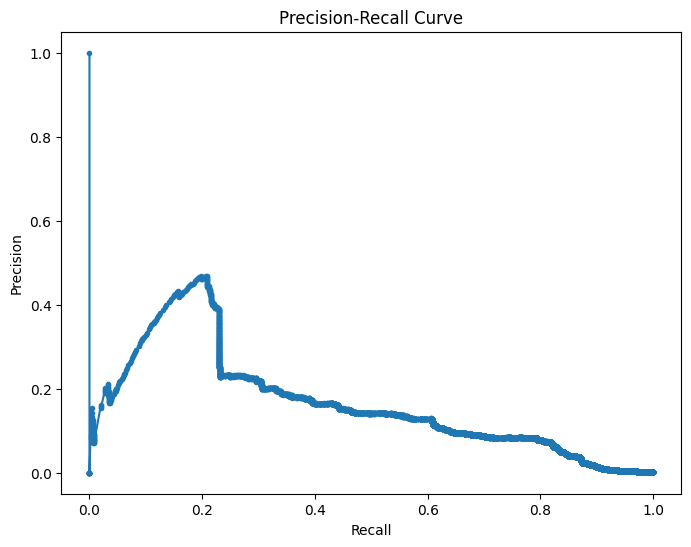

In [9]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
# Calculate precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [10]:
print(error_df.columns)

Index(['Reconstruction_error', 'True_class'], dtype='object')


In [21]:
# Set a Threshold and Detect Anomalies
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define a threshold for classifying as anomaly (fraud) or normal
threshold = 50  # adjust based on your data distribution and needs

# Generate predictions: 1 if the reconstruction error > threshold, else 0
error_df['predicted_class'] = [1 if e > threshold else 0 for e in error_df['Reconstruction_error'].values]

# Calculate the metrics
accuracy = accuracy_score(error_df['True_class'], error_df['predicted_class'])
precision = precision_score(error_df['True_class'], error_df['predicted_class'])
recall = recall_score(error_df['True_class'], error_df['predicted_class'])

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9981
Precision: 0.4251
Recall: 0.2134


True Negatives (TN): 284173
False Positives (FP): 142
False Negatives (FN): 387
True Positives (TP): 105


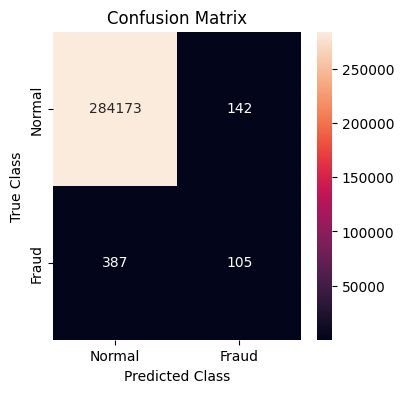

In [22]:
#Evaluate the Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(error_df.True_class, error_df.predicted_class)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print the values
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

# Plotting the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


In [28]:
# Also, check for code on the official mail

#Steps to Implement Anomaly Detection
#Load and Explore the Data: Load the dataset and check for missing values and the class distribution.
#Preprocess the Data: Normalize features and split the dataset into training and testing sets.
#Define the Autoencoder Model: Build an Autoencoder model using Keras.
#Train the Model: Train the Autoencoder on normal (non-fraudulent) transactions.
#Calculate Reconstruction Errors: Calculate the reconstruction error for each transaction in the test set.
#Set a Threshold and Detect Anomalies: Set a threshold to classify transactions as normal or fraudulent based on reconstruction error.
#Evaluate the Model: Use a confusion matrix to evaluate the results.

In [29]:
#True Negatives (TN): (correctly predicted normal transactions)
#False Positives (FP): (incorrectly predicted as fraud)
#False Negatives (FN): (incorrectly predicted as normal)
#True Positives (TP): (correctly predicted fraud)